# Final capstone project

## Completeness venues rate in Jakarta to refer people to buy house. 

## A. Introduction

### A.1 Description and Discussion Background

Jakarta has most density in Indonesia with 9.6 million people live. It has 661,5 SqKm with 14.464 people per square kilometer. The city is divided to 5 borough East, West, South,North and Center Jakarta. As an Indonesian, I use my capital city in my project. As a capital city and a business city, Jakarta has high price real estates. If people want to live in Jakarta, it should cost around Rp. 2.000.0000 - Rp. 5.000.000 average per month to rent an apartment or a boarding house, and around Rp. 500.000.000 - Rp. 1.000.000.000 for an apartment, of course it depends on the location. When we start to think to live in Jakarta, we may want to choose the best location for us with vary venues like cafe, hospital, etc and low cost absolutely. However it is difficult to obtain the information to determine which real estate we should buy. Will the house really worth it or not.

When we consider all the parameter, we can create a information chart where the real estate is placed and each district is clutered according to the venues.

### A.2 Data Description

This is the data I will use:

- https://ekonomi.bisnis.com/read/20171110/48/708065/berikut-pergerakana-harga-properti-di-jakarta Average house price in jakarta
- Foursquare API to show venues around the borough
- Jakarta geojson from https://gist.github.com/heffergm/d261f9cf3b334b8e523ee7fe0b3ef583?short_path=8e72f60

## B. Methodology

I used github to store my database. My main data include Borough, sub-district, average pricing house in Jakarta based on ekonomi.bisnis.com, latitude and longitude. I used python for my programming language cause it has a tons of library that can help me to analyze. I used folium to visualize geographic detail of Jakarta.

1. Importing all libraries that I Need

In [198]:
import pandas as pd
from pandas.io.json import json_normalize
import numpy as np
import folium
import requests
from shapely.geometry import Point, Polygon, LineString
import json
import matplotlib.pyplot as plt

2. I scrapped from https://ekonomi.bisnis.com/read/20171110/48/708065/berikut-pergerakana-harga-properti-di-jakarta  to obtain price information every borough in Jakarta

In [2]:
datas = [['East Jakarta',7900,-6.225,106.900],['West Jakarta',13200,-6.167,106.763],['North Jakarta',17100,-6.155,106.892],['South Jakarta',17900,-6.261,106.810],['Central Jakarta',18700,-6.2088,106.845]]
df = pd.DataFrame(datas)
df.columns = ['Borugh','Avg Price','Latitude','Longitude']
df

Borugh  Avg Price  Latitude  Longitude
0     East Jakarta       7900   -6.2250    106.900
1     West Jakarta      13200   -6.1670    106.763
2    North Jakarta      17100   -6.1550    106.892
3    South Jakarta      17900   -6.2610    106.810
4  Central Jakarta      18700   -6.2088    106.845

I conclude from the data above that average price in East Jakarta is the cheapest one.

The next step is to analyze data from every borough but the output is too large because every borough has more than 100 sqkm area except central Jakarta. So I try to make more detail and use every sub-district in Jakarta. 

Bordering every sub-district in Jakarta using *Jakarta geojson* 

In [3]:
jakarta_lat = -6.2088
jakarta_long = 106.8456
state_geo = 'jakarta_by_kelurahan_geo.geojson'

m = folium.Map(location=[jakarta_lat,jakarta_long], zoom_start=12)

folium.Choropleth(
    geo_data=state_geo,
    name='choropleth',
    fill_color='BuPu',
    fill_opacity=0.3,
    line_opacity=0.8
).add_to(m)

folium.LayerControl().add_to(m)

m

So I will use the data from sub-district to find every venues such as Movie theater, academic, food, animal shelter, market, bank, tranportation using foursquare *API*. The data from Foursquare can be analyzed so we can retrieve insight the most worth it place to buy a house.

To retrieve data from foursquare I need every center latitude and longitude.

In [5]:
with open('jakarta_by_kelurahan_geo.geojson') as f:
    data = json.load(f)

# data['features']
for feature in data['features']:
#     print(feature['geometry']['coordinates'][0][0])
    p = Polygon(feature['geometry']['coordinates'][0][0])
    point = p.centroid
    
    folium.CircleMarker(
        [point.y, point.x],
        radius=5,
        color='blue',
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(m)
m

Every center of sub-district is defined. So now I try to make function to retrieve every venues in sub-district using foursquare api

In [6]:
CLIENT_ID = 'VF1SBTXRNXKEDALWBRLRE2NT2K0Z3WVTUD3TGPV2DA5HOB3B' # your Foursquare ID
CLIENT_SECRET = 'WQI03FWI4MIEQVY0PRJYDAUOZJA1P0COTYGYSMFVQ2VXLAEI' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 500
categoryId='4bf58dd8d48988d13b941735' #category id for food category
categories=[
    {'name':'Movie Theater','code':'4bf58dd8d48988d17f941735'},
    {'name':'College Academic Building','code':'4bf58dd8d48988d198941735'},
    {'name':'Asian Restaurant','code':'4bf58dd8d48988d142941735'},
    {'name':'Indonesian Restaurant','code':'4deefc054765f83613cdba6f'},
    {'name':'Bar','code':'4bf58dd8d48988d116941735'},
    {'name':'Athletics & Sports','code':'4f4528bc4b90abdf24c9de85'},
    {'name':'School','code':'4bf58dd8d48988d13b941735'},
    {'name':'Animal Shelter','code':'4e52d2d203646f7c19daa8ae'},
    {'name':'Spiritual Center','code':'4bf58dd8d48988d131941735'},
    {'name':'ATM','code':'52f2ab2ebcbc57f1066b8b56'},
    {'name':'Bank','code':'4bf58dd8d48988d10a951735'},
    {'name':'Market','code':'50be8ee891d4fa8dcc7199a7'},
    {'name':'Bus Station','code':'4bf58dd8d48988d1fe931735'},
    {'name':'Train Station','code':'4bf58dd8d48988d129951735'},
    {'name':'Hospital','code':'4bf58dd8d48988d196941735'},
    {'name':'Pharmacy','code':'4bf58dd8d48988d10f951735'},
    {'name':'Garden','code':'4bf58dd8d48988d15a941735'}
]

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)


# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']

    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

def generate_venue(lat,lng):
    ll = '{},{}'.format(lat,lng)
    sortByPopularity = '1'
    search_query = ''
    radius = 500
    print(search_query + ' .... OK!')
    url = 'https://api.foursquare.com/v2/venues/search?categoryId={}&ll={}&sortByPopularity={}&client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(categoryId,ll,sortByPopularity,CLIENT_ID, CLIENT_SECRET, jakarta_lat, jakarta_long, VERSION, search_query, radius, LIMIT)

    
    results = requests.get(url).json()
    
    # assign relevant part of JSON to venues
    venues = results['response']['venues']

    # tranform venues into a dataframe
    dataframe = json_normalize(venues)
    
    
    # keep only columns that include venue name, and anything that is associated with location
    filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
    dataframe_filtered = dataframe.loc[:, filtered_columns]

    # filter the category for each row
    dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

    # clean column names by keeping only last term
    dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]

#     for lati, long, label in zip(dataframe_filtered.lat, dataframe_filtered.lng, dataframe_filtered.categories):
#         folium.CircleMarker(
#             [lati, long],
#             radius=5,
#             color='blue',
#             popup=label,
#             fill = True,
#             fill_color='blue',
#             fill_opacity=0.6
#         ).add_to(m)
    
    return dataframe

Your credentails:
CLIENT_ID: VF1SBTXRNXKEDALWBRLRE2NT2K0Z3WVTUD3TGPV2DA5HOB3B
CLIENT_SECRET:WQI03FWI4MIEQVY0PRJYDAUOZJA1P0COTYGYSMFVQ2VXLAEI


In [7]:
def generate_url(lat,lng,categoryId):
    CLIENT_ID = 'VF1SBTXRNXKEDALWBRLRE2NT2K0Z3WVTUD3TGPV2DA5HOB3B' # your Foursquare ID
    CLIENT_SECRET = 'PKKKM3LVQ2LQXTX4G0TV13ULTMPFYNJO3NNXQHFPAPIAEAB1' # your Foursquare Secret
    VERSION = '20180604'
    LIMIT = 500
    ll = '{},{}'.format(lat,lng)
    sortByPopularity = '1'
    search_query = ''
    radius = 500
    url = 'https://api.foursquare.com/v2/venues/search?categoryId={}&ll={}&sortByPopularity={}&client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(categoryId,ll,sortByPopularity,CLIENT_ID, CLIENT_SECRET, jakarta_lat, jakarta_long, VERSION, search_query, radius, LIMIT)
    return url

def find_venues(lat,lng,subDistrictName):
    environments = pd.DataFrame()
    print('Finding venues arround {}'.format(subDistrictName))
    for category in categories:
        url = generate_url(lat,lng,category['code'])
        results = requests.get(url).json()
#         print(results)
        
        try:
            venues = results['response']['venues']
            dataframe = json_normalize(venues)
            environment = dataframe[['name','location.lat','location.lng']]
            environment['sub-district'] = subDistrictName
            environment['sd-lat'] = lat
            environment['sd-lng'] = lng
            environment['category'] = category['name']
            environments = environments.append(environment)
            print('{} has {} {}'.format(subDistrictName,len(environments.index),category['name']))
        except :
            print("{} doesn't has {}".format(subDistrictName,category['name']))
            
            
            
        
    return environments
    

I commend the code below, so I don't execute every time. The data I extract to csv file format so I can easily access without retrieve again using foursquare API

In [9]:
# df_venues =  pd.DataFrame()
# for feature in data['features']:
#     df_temp = pd.DataFrame()
#     p = Polygon(feature['geometry']['coordinates'][0][0])
#     point = p.centroid
#     df_temp = find_venues(point.y,point.x,feature['properties']['name'])
#     df_venues = df_venues.append(df_temp)

# df_venues.to_csv('venues_2.csv')

In [10]:
df = pd.read_csv('venues_2.csv')
df.head()

Unnamed: 0             name  location.lat  location.lng sub-district  \
0           0   Bengkel Ko Aji     -6.145625    106.790205        ANGKE   
1           1          TV Room     -6.145872    106.796391        ANGKE   
2           2  Season City XX1     -6.149000    106.794503        ANGKE   
3           3        My Cinema     -6.145094    106.798164        ANGKE   
4           4     XXI Junction     -6.140917    106.794491        ANGKE   

     sd-lat      sd-lng       category  
0 -6.145663  106.795697  Movie Theater  
1 -6.145663  106.795697  Movie Theater  
2 -6.145663  106.795697  Movie Theater  
3 -6.145663  106.795697  Movie Theater  
4 -6.145663  106.795697  Movie Theater

The data I retrieve is vertical, I want to make the data more clear so I can see every subdistrict has how many Movie Theater or something. I want to state every step to make the data that I want.

#### 1. Get unique category to make columns

In [11]:
categories = df['category'].unique()
sub_district = df['sub-district'].unique()
df_categories = pd.DataFrame(columns=categories)
df_categories.insert(0,'sub-district',sub_district)
df_categories.head()

sub-district Movie Theater College Academic Building Asian Restaurant  \
0        ANGKE           NaN                       NaN              NaN   
1      PASEBAN           NaN                       NaN              NaN   
2     KRENDANG           NaN                       NaN              NaN   
3      TAMBORA           NaN                       NaN              NaN   
4  DUREN SAWIT           NaN                       NaN              NaN   

  Indonesian Restaurant  Bar Athletics & Sports School Spiritual Center Bank  \
0                   NaN  NaN                NaN    NaN              NaN  NaN   
1                   NaN  NaN                NaN    NaN              NaN  NaN   
2                   NaN  NaN                NaN    NaN              NaN  NaN   
3                   NaN  NaN                NaN    NaN              NaN  NaN   
4                   NaN  NaN                NaN    NaN              NaN  NaN   

  Market Bus Station Train Station Hospital Pharmacy  ATM Garden  \
0    NaN         NaN           NaN      NaN      NaN  NaN    NaN   
1    NaN         NaN           NaN      NaN      NaN  NaN    NaN   
2    NaN         NaN           NaN      NaN      NaN  NaN    NaN   
3    NaN         NaN           NaN      NaN      NaN  NaN    NaN   
4    NaN         NaN           NaN      NaN      NaN  NaN    NaN   

  Animal Shelter  
0            NaN  
1            NaN  
2            NaN  
3            NaN  
4            NaN

#### 2. Set sub-district to become index.

In [12]:
df_categories.set_index('sub-district',inplace=True)

#### 3. Generate every summary of venues to sub-district

In [13]:
df_filter = df[['sub-district','category']]
for indexa in df_categories.index:
    for row in df_categories.columns:
        temp = df_filter[(df_filter['sub-district'] == indexa) & (df_filter['category'] == row)]
        index = temp.index
        result = len(index)
        df_categories.loc[indexa][row] = result
df_categories.head()

Movie Theater College Academic Building Asian Restaurant  \
sub-district                                                            
ANGKE                    5                         8               48   
PASEBAN                  2                        14               46   
KRENDANG                 5                         5               50   
TAMBORA                  2                        14               46   
DUREN SAWIT              2                        14               46   

             Indonesian Restaurant Bar Athletics & Sports School  \
sub-district                                                       
ANGKE                           46   6                 16     34   
PASEBAN                         45   5                 18     10   
KRENDANG                        49   2                 27     49   
TAMBORA                         45   5                 18     10   
DUREN SAWIT                     45   5                 18     10   

             Spiritual Center Bank Market Bus Station Train Station Hospital  \
sub-district                                                                   
ANGKE                      47   17      6           6             3        5   
PASEBAN                    46   22      5          10            13       30   
KRENDANG                   29   37      8           0             0       11   
TAMBORA                    46   22      5          10            13       30   
DUREN SAWIT                46   22      5          10            13       30   

             Pharmacy ATM Garden Animal Shelter  
sub-district                                     
ANGKE               8   0      0              0  
PASEBAN             5   1      1              0  
KRENDANG            7   0      4              1  
TAMBORA             5   1      1              0  
DUREN SAWIT         5   1      1              0

I got summary every Venues. My next move is to merge every venues category into bins. The bins are Entertaiment, education, Finance Food, Health, transportation and others.
Entertaiment covers:
- Movie Theater
- Garden
- Bar

Education covers:
- College Academic Building
- School

Food covers:
- Asian Restaurant
- Indonesian Restaurant

Health covers:
- Hospital
- Pharmacy

Transportation covers:
- Bus Station
- Train Station

Finance covers:
- Bank
- ATM

The rest is include to others.

In [23]:
df_bins = df_categories
df_bins['Entertaiment'] = df_categories['Movie Theater'] + df_categories['Garden'] + df_categories['Bar']
df_bins['Education'] = df_categories['College Academic Building'] + df_categories['School']
df_bins['Food'] = df_categories['Asian Restaurant'] + df_categories['Indonesian Restaurant'] 
df_bins['Health'] = df_categories['Hospital'] + df_categories['Pharmacy'] 
df_bins['Transportation'] = df_categories['Bus Station'] + df_categories['Train Station']
df_bins['Finance'] = df_categories['Bank'] + df_categories['ATM']
df_bins['Other'] = df_categories['Athletics & Sports'] + df_categories['Spiritual Center'] + df_categories['Market'] + df_categories['Animal Shelter']
df_bins.head()

Movie Theater College Academic Building Asian Restaurant  \
sub-district                                                            
ANGKE                    5                         8               48   
PASEBAN                  2                        14               46   
KRENDANG                 5                         5               50   
TAMBORA                  2                        14               46   
DUREN SAWIT              2                        14               46   

             Indonesian Restaurant Bar Athletics & Sports School  \
sub-district                                                       
ANGKE                           46   6                 16     34   
PASEBAN                         45   5                 18     10   
KRENDANG                        49   2                 27     49   
TAMBORA                         45   5                 18     10   
DUREN SAWIT                     45   5                 18     10   

             Spiritual Center Bank Market  ... ATM Garden Animal Shelter  \
sub-district                               ...                             
ANGKE                      47   17      6  ...   0      0              0   
PASEBAN                    46   22      5  ...   1      1              0   
KRENDANG                   29   37      8  ...   0      4              1   
TAMBORA                    46   22      5  ...   1      1              0   
DUREN SAWIT                46   22      5  ...   1      1              0   

             Entertaiment Education Food Health Transportation Finance Other  
sub-district                                                                  
ANGKE                  11        42   94     13              9      17    69  
PASEBAN                 8        24   91     35             23      23    69  
KRENDANG               11        54   99     18              0      37    65  
TAMBORA                 8        24   91     35             23      23    69  
DUREN SAWIT             8        24   91     35             23      23    69  

[5 rows x 24 columns]

In [28]:
df_bins.drop(df_bins.columns[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]],axis=1,inplace=True)

In [29]:
df_bins.head()

Entertaiment Education Food Health Transportation Finance Other
sub-district                                                                
ANGKE                  11        42   94     13              9      17    69
PASEBAN                 8        24   91     35             23      23    69
KRENDANG               11        54   99     18              0      37    65
TAMBORA                 8        24   91     35             23      23    69
DUREN SAWIT             8        24   91     35             23      23    69

Dataframe with bins inside has created. I have a mass data from sub-district. I try to analyze in East Jakarta, because it has the lowest average price house. I scrapped from https://www.infojabodetabek.com/daftar-kecamatan-dan-kelurahan-di-kota-jakarta-timur/ to retrieve all sub-district in East Jakarta.

In [75]:
sub_district_east_jakarta_path = 'data/east_jakarta_sub_district.csv'
sub_district_east_jakarta = pd.read_csv(sub_district_east_jakarta_path)
sub_district_east_jakarta = sub_district_east_jakarta['sub-district'].str.upper().to_list()

Check if sub districts in East jakarta from https://www.infojabodetabek.com/daftar-kecamatan-dan-kelurahan-di-kota-jakarta-timur/ exist in all sub district

In [128]:
allsubdis = df_bins.index
unfoundSubDis = []
for subdis in sub_district_east_jakarta:
    if subdis not in allsubdis:
        print('{} is not present in the list'.format(subdis))
        unfoundSubDis.append(subdis)

PONDOK RANGGON is not present in the list
BALEKAMBANG is not present in the list
TENGAH is not present in the list
PINANGRANTI is not present in the list
PALMERIAM is not present in the list
PULO GADUNG is not present in the list


Check subdistrict in east jakarta that doesn't exist in all subdistrict

In [85]:
if any("PONDOK RANGON" in s for s in allsubdis):
    print('EXIST')
else:
    print("DOESN'T EXIST")

EXIST


In [99]:
if any("BALE" in s for s in allsubdis):
    print('EXIST')
else:
    print("DOESN'T EXIST")

EXIST


In [100]:
matching = [s for s in allsubdis if "BALE" in s]
matching

['BALE KAMBANG']

In [130]:
if any("TENGAH" in s for s in allsubdis):
    print('EXIST')
else:
    print("DOESN'T EXIST")

EXIST


In [135]:
matching = [s for s in allsubdis if "TENGAH" in s]
matching

['KAMPUNG TENGAH']

In [105]:
if any("PINANG RANTI" in s for s in allsubdis):
    print('EXIST')
else:
    print("DOESN'T EXIST")

EXIST


In [111]:
if any("PALMER" in s for s in allsubdis):
    print('EXIST')
else:
    print("DOESN'T EXIST")

EXIST


In [114]:
matching = [s for s in allsubdis if "PAL" in s]
matching

['KEBON PALA', 'PAL MERIAM', 'PALMERAH']

In [116]:
if any("PULOGADUNG" in s for s in allsubdis):
    print('EXIST')
else:
    print("DOESN'T EXIST")

EXIST


Renaming the data

In [148]:
def changeName(before,after):
    i = sub_district_east_jakarta.index(before)
    sub_district_east_jakarta[i] = after

In [149]:
changeName('PONDOK RANGGON','PONDOK RANGON')
changeName('BALEKAMBANG','BALE KAMBANG')
changeName('PINANGRANTI','PINANG RANTI')
changeName('PALMERIAM','PAL MERIAM')
# changeName('PULO GADUNG','PULOGADUNG')

In [150]:
allsubdis = df_bins.index
unfoundSubDis = []
for subdis in sub_district_east_jakarta:
    if subdis not in allsubdis:
        print('{} is not present in the list'.format(subdis))
        unfoundSubDis.append(subdis)

TENGAH is not present in the list


Deleting 'Tengah' because there is not matched data.

In [153]:
i = sub_district_east_jakarta.index('TENGAH')
del sub_district_east_jakarta[i]

In [154]:
allsubdis = df_bins.index
unfoundSubDis = []
for subdis in sub_district_east_jakarta:
    if subdis not in allsubdis:
        print('{} is not present in the list'.format(subdis))
        unfoundSubDis.append(subdis)

In [160]:
df_bins_east_jakarta = df_bins.loc[sub_district_east_jakarta]
df_bins_east_jakarta.head(15)

Entertaiment Education Food Health Transportation Finance Other
sub-district                                                                 
CAKUNG BARAT             0         8    9      0              0       1     9
CAKUNG TIMUR             8        24   91     35             23      23    69
JATINEGARA               3         3   41      1              2       8    14
PENGGILINGAN             8        24   91     35             23      23    69
PULO GEBANG              8        24   91     35             23      23    69
RAWA TERATE              1         2   54      2             13       9    11
UJUNG MENTENG            8        24   91     35             23      23    69
BAMBU APUS               8        24   91     35             23      23    69
CEGER                    6        13   70      6              1       7    19
CILANGKAP                0         2   14      0              0       3     8
CIPAYUNG                 8        24   91     35             23      23    69
LUBANG BUAYA             8        24   91     35             23      23    69
MUNJUL                   2        10   48      5              1       3    13
PONDOK RANGON            8        24   91     35             23      23    69
SETU                     8        24   91     35             23      23    69

Finding sub-district with all category venues is exist

In [176]:
df_filtered = df_bins_east_jakarta[~(df_bins_east_jakarta['Entertaiment'] == 0) 
                     & ~(df_bins_east_jakarta['Education'] == 0)
                     & ~(df_bins_east_jakarta['Food'] == 0)
                     & ~(df_bins_east_jakarta['Health'] == 0)
                     & ~(df_bins_east_jakarta['Transportation'] == 0)
                     & ~(df_bins_east_jakarta['Finance'] == 0)
                     & ~(df_bins_east_jakarta['Other'] == 0)]

In [177]:
df_filtered['Total_venues'] = df_filtered.sum(axis=1)

<ipython-input-177-33fca25762f9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Total_venues'] = df_filtered.sum(axis=1)


Result 5 subdistricts order by total venues in their area.

In [189]:
df_result = df_filtered.sort_values(by=['Total_venues'], ascending=False).head()

In [242]:
df_result

Entertaiment Education Food Health Transportation Finance Other
sub-district                                                                  
RAWAMANGUN               13        92   98     38             21      48    76
RAWA BUNGA                6        46   95     64             20      32    61
PINANG RANTI             17        26   93     57             23      21    47
BIDARA CINA               8        24   91     35             23      23    69
KAMPUNG MELAYU            8        24   91     35             23      23    69

## VISUALIZATION

### Barchart

In [193]:
df_result = df_result.drop('Total_venues',axis=1)
df_result

Entertaiment Education Food Health Transportation Finance Other
sub-district                                                                  
RAWAMANGUN               13        92   98     38             21      48    76
RAWA BUNGA                6        46   95     64             20      32    61
PINANG RANTI             17        26   93     57             23      21    47
BIDARA CINA               8        24   91     35             23      23    69
KAMPUNG MELAYU            8        24   91     35             23      23    69

Text(0.5, 1.0, 'Total venues in East Jakarta')

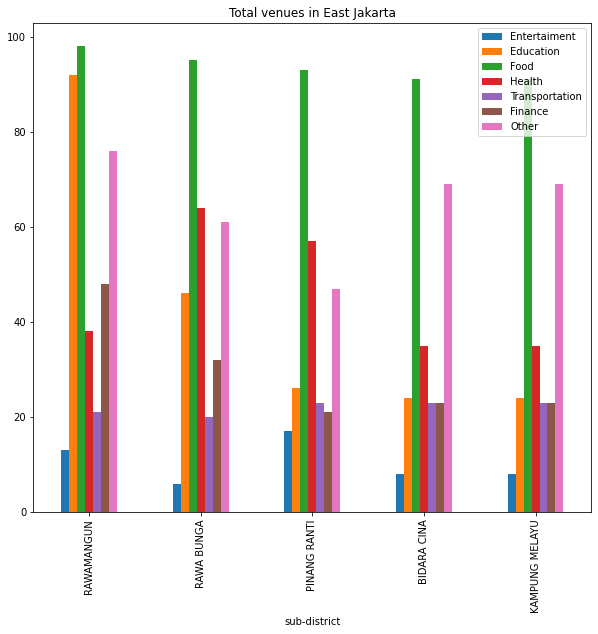

In [202]:
df_result.plot(kind='bar',figsize=(10,9));
plt.title('Total venues in East Jakarta')

The result is Rawamangun, Rawa Bunga, Pinang Ranti, Bidara Cina, Kampung Melayu. They have the most widely venues in their area. Let's visualize all venues in their area in using folium

## GEOVISUALIZATION

#### 1. Get all venues lat and lng to visualize in Folium.

In [268]:
result = df_result.index.to_list()
df_vis = df[df['sub-district'].isin(result)]
df_vis.head()

Unnamed: 0                                  name  location.lat  \
3602        3602                    Pasaraya manggarai     -6.212861   
3603        3603  Kusuma's Home Theatre & Karaoke Room     -6.208762   
3604        3604                      PAUD minangkabau     -6.210520   
3605        3605         Classroom Pusdiklat Jiwasraya     -6.210495   
3606        3606          Lembaga pendidikan metoda 21     -6.210260   

      location.lng sub-district    sd-lat      sd-lng  \
3602    106.845001  BIDARA CINA -6.235361  106.866972   
3603    106.845595  BIDARA CINA -6.235361  106.866972   
3604    106.845200  BIDARA CINA -6.235361  106.866972   
3605    106.844460  BIDARA CINA -6.235361  106.866972   
3606    106.847462  BIDARA CINA -6.235361  106.866972   

                       category  
3602              Movie Theater  
3603              Movie Theater  
3604  College Academic Building  
3605  College Academic Building  
3606  College Academic Building

In [269]:
df_vis.drop(['Unnamed: 0'],axis=1)

name  location.lat  location.lng  \
3602                     Pasaraya manggarai     -6.212861    106.845001   
3603   Kusuma's Home Theatre & Karaoke Room     -6.208762    106.845595   
3604                       PAUD minangkabau     -6.210520    106.845200   
3605          Classroom Pusdiklat Jiwasraya     -6.210495    106.844460   
3606           Lembaga pendidikan metoda 21     -6.210260    106.847462   
...                                     ...           ...           ...   
57040                Am's Herbal sunan giri     -6.197340    106.885970   
57041             EDWARD SUPLEMENMANIA SHOP     -6.196733    106.883143   
57042                       Taman Sringanis     -6.197397    106.885460   
57043                               Century     -6.198386    106.886157   
57044          Pemakaman Kemiri - Rw Mangun     -6.195015    106.882400   

      sub-district    sd-lat      sd-lng                   category  
3602   BIDARA CINA -6.235361  106.866972              Movie Theater  
3603   BIDARA CINA -6.235361  106.866972              Movie Theater  
3604   BIDARA CINA -6.235361  106.866972  College Academic Building  
3605   BIDARA CINA -6.235361  106.866972  College Academic Building  
3606   BIDARA CINA -6.235361  106.866972  College Academic Building  
...            ...       ...         ...                        ...  
57040   RAWAMANGUN -6.195916  106.882518                   Pharmacy  
57041   RAWAMANGUN -6.195916  106.882518                   Pharmacy  
57042   RAWAMANGUN -6.195916  106.882518                   Pharmacy  
57043   RAWAMANGUN -6.195916  106.882518                   Pharmacy  
57044   RAWAMANGUN -6.195916  106.882518                     Garden  

[1540 rows x 7 columns]

In [270]:
df_vis.reset_index()
df_vis

Unnamed: 0                                  name  location.lat  \
3602         3602                    Pasaraya manggarai     -6.212861   
3603         3603  Kusuma's Home Theatre & Karaoke Room     -6.208762   
3604         3604                      PAUD minangkabau     -6.210520   
3605         3605         Classroom Pusdiklat Jiwasraya     -6.210495   
3606         3606          Lembaga pendidikan metoda 21     -6.210260   
...           ...                                   ...           ...   
57040       57040                Am's Herbal sunan giri     -6.197340   
57041       57041             EDWARD SUPLEMENMANIA SHOP     -6.196733   
57042       57042                       Taman Sringanis     -6.197397   
57043       57043                               Century     -6.198386   
57044       57044          Pemakaman Kemiri - Rw Mangun     -6.195015   

       location.lng sub-district    sd-lat      sd-lng  \
3602     106.845001  BIDARA CINA -6.235361  106.866972   
3603     106.845595  BIDARA CINA -6.235361  106.866972   
3604     106.845200  BIDARA CINA -6.235361  106.866972   
3605     106.844460  BIDARA CINA -6.235361  106.866972   
3606     106.847462  BIDARA CINA -6.235361  106.866972   
...             ...          ...       ...         ...   
57040    106.885970   RAWAMANGUN -6.195916  106.882518   
57041    106.883143   RAWAMANGUN -6.195916  106.882518   
57042    106.885460   RAWAMANGUN -6.195916  106.882518   
57043    106.886157   RAWAMANGUN -6.195916  106.882518   
57044    106.882400   RAWAMANGUN -6.195916  106.882518   

                        category  
3602               Movie Theater  
3603               Movie Theater  
3604   College Academic Building  
3605   College Academic Building  
3606   College Academic Building  
...                          ...  
57040                   Pharmacy  
57041                   Pharmacy  
57042                   Pharmacy  
57043                   Pharmacy  
57044                     Garden  

[1540 rows x 8 columns]

#### 2. Mark all subdistrict in map

In [273]:
subdisresultcol = df_vis['sub-district'].unique()

with open('jakarta_by_kelurahan_geo.geojson') as f:
    data = json.load(f)
  
    
data['features']
for feature in data['features']:
    if any(feature['properties']['name'] in s for s in subdisresultcol):
        p = Polygon(feature['geometry']['coordinates'][0][0])
        point = p.centroid

        folium.CircleMarker(
            [point.y, point.x],
            radius=5,
            color='blue',
            fill = True,
            fill_color='blue',
            fill_opacity=0.6
        ).add_to(m)
m

#### 3. Mark every venues in result

#### 3.1 Modif df to get Main category

In [326]:
arrEntertaimen = ['Movie Theater','Garden','Bar']
arrEducation = ['College Academic Building','School']
arrFood = ['Asian Restaurant','Indonesian Restaurant']
arrHealth = ['Hospital','Pharmacy']
arrTransportation = ['Bus Station','Train Station']
arrFinance = ['Bank','ATM']
arrOther = ['Athletics & Sports','Spiritual Center','Market','Animal Shelter']

conditions = [
    (df_vis['category'].isin(arrEntertaimen)),
    (df_vis['category'].isin(arrEducation)),
    (df_vis['category'].isin(arrFood)),
    (df_vis['category'].isin(arrHealth)),
    (df_vis['category'].isin(arrTransportation)),
    (df_vis['category'].isin(arrFinance)),
    (df_vis['category'].isin(arrOther)),
]

choices = [
    'Entertaiment',
    'Education',
    'Food',
    'Health',
    'Transportation',
    'Finance',
    'Other'
]

In [329]:

df_vis['main category'] = np.select(conditions, choices, default='')

<ipython-input-329-2976c4383fa7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vis['main category'] = np.select(conditions, choices, default='')


In [331]:
a = 0
for i in df_vis.index:
    category = df_vis.loc[i]['main category']
    x = df_vis.loc[i]['location.lng']
    y = df_vis.loc[i]['location.lat']
    
    if category == 'Entertaiment':
        colour = 'white'
    elif category == 'Education':
        colour = 'yellow'
    elif category == 'Food':
        colour = 'green'
    elif category == 'Health':
        colour = 'red'
    elif category == 'Transportation':
        colour = 'purple'
    elif category == 'Finance':
        colour = 'brown'
    elif category == 'Other':
        colour = 'pink'
    
    folium.CircleMarker(
        [y, x],
        radius=5,
        color=colour,
        fill = True,
        fill_color='colour',
        fill_opacity=0.6
    ).add_to(m)
    
m

In [291]:
df_vis['category'].unique()

array(['Movie Theater', 'College Academic Building', 'Asian Restaurant',
       'Indonesian Restaurant', 'Bar', 'Athletics & Sports', 'School',
       'Spiritual Center', 'ATM', 'Bank', 'Market', 'Bus Station',
       'Train Station', 'Hospital', 'Pharmacy', 'Garden',
       'Animal Shelter'], dtype=object)